#### Quick attempt at implementing Toroidal Diffusions

Some helper functions

In [1]:
# map x to (-π, π]
cmod(x::Real) = rem2pi(x, RoundNearest);

# returns [-r,r]ᵈ ⊂ ℤᵈ
hyper_cube(r::Int, d::Int) = map(collect, vec(collect(Base.product(fill(-r:r, d)...))));

# returns 2π[-r,r]ᵈ ⊂ 2πℤᵈ
twoπ_hyper_cube(r::Int, d::Int) = 2π .* hyper_cube(r, d);

Define a Wrapped Normal distribution

In [2]:
using PDMats, Distributions

export 
struct WrappedMvNormal{T <: Real,
                       Cov <: AbstractPDMat{T},
                       Mean <: AbstractVector{T}
                       } <: ContinuousMultivariateDistribution 
    
    𝛷::MvNormal{T, Cov, Mean}      # the underlying unwrapped distribution
    𝕃::Vector{Vector{T}}           # 𝕃 ⊂ 2πℤᵈ truncated period lattice considered for computing the pdf
end


# Constructors

function WrappedMvNormal(μ::AbstractVector{T}, Σ::AbstractPDMat{T}, max_k=2) where T <: Real
    WrappedMvNormal{T, typeof(Σ), typeof(μ)}(MvNormal(μ, Σ), twoπ_hyper_cube(max_k, length(μ)))
end

function WrappedMvNormal(μ::AbstractVector{<:Real}, Σ::AbstractPDMat{<:Real}, max_k=2)
    R = Base.promote_eltype(μ, Σ)
    WrappedMvNormal(convert(AbstractArray{R}, μ), convert(AbstractArray{R}, Σ), max_k)
end

WrappedMvNormal(μ::AbstractVector{<:Real}, Σ::AbstractMatrix{<:Real}, max_k=2) = WrappedMvNormal(μ, PDMat(Σ), max_k);



# Methods

using Random, LogExpFunctions
import Base: length, eltype
import Distributions: pdf, logpdf, mean, _rand!

length(d::WrappedMvNormal) = length(d.𝛷);

eltype(d::WrappedMvNormal) = eltype(d.𝛷);

_rand!(rng::AbstractRNG, d::WrappedMvNormal, x::AbstractArray{<:Real}) =
    cmod.(_rand!(rng, d.𝛷, x))

function pdf(d::WrappedMvNormal, x::AbstractVector)
    θ = cmod.(x)
    sum(pdf.(Ref(d.𝛷), Ref(θ) .+ d.𝕃))
end

function logpdf(d::WrappedMvNormal, x::AbstractVector) 
    θ = cmod.(x)
    logsumexp(logpdf.(Ref(d.𝛷), Ref(θ) .+ d.𝕃)); # Ref stops arguments from being broadcasted
end

mean(d::WrappedMvNormal) = mean(d.𝛷);
    
function plotpdf(d::WrappedMvNormal, step=0.05)
    Z = [pdf(d,[j,i]) for i in -π:step:π, j in -π:step:π]
    heatmap(-π:step:π, -π:step:π, Z, size=(400, 400), title="WN Density")
end;

Quick sanity checks

WrappedMvNormal{Float64, PDiagMat{Float64, Vector

{Float64}}, Vector{Float64}}
2
Float64
[2.5, 0.5]


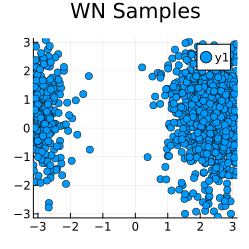

In [5]:
w = WrappedMvNormal([2.5, 0.5], PDiagMat([0.6, 1.5]), 3)

println(typeof(w))

println(length(w))
println(eltype(w))
println(mean(w))

using Plots

samples = rand(w, 1000)
scatter(samples[1, :], samples[2, :], size=(250,250), xlims=(-π, π), ylims=(-π, π), title="WN Samples")

In [ ]:
plotpdf(w)

Now we can begin to define the WN OU diffusion. For that we just need the transition probability distribution, since the process is Markovian. It doesn't have a nice closed form so we use an approximation. 

But first, more helper functions...

In [ ]:
using LinearAlgebra
𝑟(A::AbstractMatrix{<:Real}) = tr(A) / 2;
𝑞(A::AbstractMatrix{<:Real}) = √(abs(det(A - 𝑟(A)I)));
𝑎(t::Real, r::Real, q::Real) = exp(-r*t)*(cosh(q*t) + r * sinh(q*t) / q);
𝑏(t::Real, r::Real, q::Real) = exp(-r*t)*(sinh(q*t) / q);
𝑠(t::Real, r::Real, q::Real) = 1 - 𝑎(2t, r, q);
𝑖(t::Real, r::Real, q::Real) = 𝑏(2t, r, q) / 2;

In [ ]:
struct WrappedDiffusion{T <: Real, 
                        Mat <: AbstractMatrix{T},
                        InfCov <: AbstractPDMat{T},
                        StatCov <: AbstractPDMat{T},
                        Mean <: AbstractVector{T}}
    μ::Mean                                # mean
    Σ::InfCov                              # infinitesimal covariance
    A::Mat                                 # drift

    _½A⁻¹Σ::StatCov                        # stationary covariance
    
    𝕃::Vector{Vector{T}}                   # truncated winding lattice
    
    wn_stat::WrappedMvNormal{T, StatCov, Mean} # stationary distribution
    
    r::Real                                # 𝑟(A)
    q::Real                                # 𝑞(A)
end

In [ ]:

# Constructors 

function WrappedDiffusion(μ::AbstractVector{T}, Σ::AbstractPDMat{T}, A::AbstractMatrix{T}, max_k=2) where T <: Real
    _½A⁻¹Σ = PDMat(0.5 * inv(A) * Σ)
    WrappedDiffusion{T, typeof(A), typeof(Σ), typeof(_½A⁻¹Σ), typeof(μ)}(μ, Σ, A, _½A⁻¹Σ, 
                                                                         twoπ_hyper_cube(max_k, length(μ)),
                                                                         WrappedMvNormal(μ, _½A⁻¹Σ, max_k),
                                                                         𝑟(A), 𝑞(A))
end

function WrappedDiffusion(μ::AbstractVector{<:Real}, 
                          Σ::AbstractPDMat{<:Real}, 
                          A::AbstractMatrix{<:Real}, 
                          max_k=2)
    R = Base.promote_eltype(μ, Σ, A)
    WrappedMvNormal(convert(AbstractArray{R}, μ),
                    convert(AbstractArray{R}, Σ),
                    convert(AbstractArray{R}, A),
                    max_k)
end

WrappedDiffusion(μ::AbstractVector{<:Real}, 
                 Σ::AbstractMatrix{<:Real}, 
                 A::AbstractMatrix{<:Real},
                 max_k=2) = 
    WrappedDiffusion(μ, PDMat(Σ), A, max_k)


# Constructor for 2-dimensional drift
# σ -- variance coefficient of each angle
# α -- drift coefficient for each angle, as well as their drift covariance
function WrappedDiffusion(μ::AbstractVector{<:Real}, 
                          σ_𝜙::Real, σ_𝜓::Real, 
                          α_𝜙::Real, α_𝜓::Real, α_cov::Real, 
                          max_k=2)
    @assert length(μ) == 2
    @assert α_𝜙 * α_𝜓 > α_cov^2
    @assert σ_𝜙 * σ_𝜓 > 0
    
    Σ = PDiagMat([σ_𝜙^2, σ_𝜓^2])
    A = [α_𝜙 (σ_𝜙*α_cov/σ_𝜓); (σ_𝜓*α_cov/σ_𝜙) σ_𝜓]
    
    WrappedDiffusion(μ, Σ, A, max_k)
end


In [ ]:
# Methods

mean(𝚯::WrappedDiffusion) = 𝚯.μ

length(𝚯::WrappedDiffusion) = length(𝚯.μ)

weight(𝚯::WrappedDiffusion, k::AbstractVector{<:Real}, θ::AbstractVector) =
    pdf(𝚯.wn_stat.𝛷, θ + k) / pdf(𝚯.wn_stat, θ + k)


logweight(𝚯::WrappedDiffusion, k::AbstractVector{<:Real}, θ::AbstractVector) =
    logpdf(𝚯.wn_stat.𝛷, θ + k) - logpdf(𝚯.wn_stat, θ + k)


function Γ_2D(𝚯::WrappedDiffusion, t::Real)
    @assert t > 0
    𝑠(t, 𝚯.r, 𝚯.q) * 𝚯._½A⁻¹Σ + 𝑖(t, 𝚯.r, 𝚯.q) * 𝚯.Σ
end

matexp_2D(𝚯::WrappedDiffusion, t::Real) =
    𝑎(t, 𝚯.r, 𝚯.q) * I + 𝑏(t, 𝚯.r, 𝚯.q) * 𝚯.A


function tpd(𝚯::WrappedDiffusion, t::Real, θ₀::AbstractVector, θₜ::AbstractVector)
    if t < eps(typeof(t)) # if t == 0, distribution degenerates into Dirac(θ₀)
        return θ₀== θₜ
    end
    
    if length(𝚯) == 2
        Γₜ = Γ_2D(𝚯, t)
        e⁻ᵗᴬ= matexp_2D(𝚯, t) 
    else
        throw("tpd only implemented for 2 dimensions")
    end
    
    wn_Γₜ= WrappedMvNormal(𝚯.μ, Γₜ)
    
    sum(map(m -> pdf(wn_Γₜ, θₜ - e⁻ᵗᴬ * (θ₀ - 𝚯.μ + m)) * weight(𝚯, m, θₜ), 𝚯.𝕃))
end;
    
function logtpd(𝚯::WrappedDiffusion, t::Real, θ₀::AbstractVector, θₜ::AbstractVector)
    if t < eps(typeof(t)) # if t == 0, distribution degenerates into Dirac(θ₀)
        return log(θ₀== θₜ)
    end
                
    if length(𝚯) == 2
        Γₜ = Γ_2D(𝚯, t)
        e⁻ᵗᴬ= matexp_2D(𝚯, t) 
    else
        throw("logtpd only implemented for 2 dimensions")
    end
    
    wn_Γₜ= WrappedMvNormal(𝚯.μ, Γₜ)
    
    logsumexp(map(m -> logpdf(wn_Γₜ, θₜ - e⁻ᵗᴬ * (θ₀ - 𝚯.μ + m)) + logweight(𝚯, m, θₜ), 𝚯.𝕃))
end;

In [ ]:
𝚯 = WrappedDiffusion([0.0, 0.0], 1.0, 2.0, 3.0, 5.0, 1.0, 2);

println(log(tpd(𝚯, 100.4, [1.0, 0.0], [0.0, 0.0])))
println(logtpd(𝚯, 100.4, [1.0, 0.0], [0.0, 0.0]))
plotpdf(𝚯.wn_stat)

In [ ]:
θ₀= [-3.0, 3.0]
t_step = 0.2
last = 3.0

times=[0.0, 0.00001, 0.0001, 0.001, 0.01, 0.1, 0.2, 0.3, 0.5, 0.7, 1.0, 1.5, 2.0, 5.0, 10.0, 30.0, 68.0, 150.0, 300.0]

anim = @animate for t ∈ times
    println(t)
    Z = [tpd(𝚯, t, θ₀, [j, i]) for i in -π:0.1:π, j in -π:0.1:π]
    heatmap(-π:0.1:π, -π:0.1:π, Z, size=(400,400), title="TPD t=" * string(t))
end
    
gif(anim, "diffuse.gif", fps=10)